# Introduction

Warsaw is the capital and largest city of Poland. The metropolis stands on the Vistula River in east-central Poland and its population is officially estimated at 1.8 million residents within a greater metropolitan area of 3.1 million residents, which makes Warsaw the 7th most-populous capital city in the European Union. More and more people decides to move to Warsaw wheather it's because of work or studies.


This project is mainly directed toward people who are planning to rent an apartament in Warsaw. Let's suppose you are that person. When moving to Warsaw you probably need to take into account few factors such as price, area, location of the apartment as well as venues in a particular area. The main purpose of conducted analysis is to get an answers on the following questions:

1. Which district of Warsaw is the most expensive?
2. Which district has the most venues to offer?
3. Is there any correlation between these factors (price, number of venues)?


Those kind of research would be also helpful for a flat owner who wants to rent a flat and need to set a rental price.

# Data

### This project rely on public data from Wikipedia, Foursquare API and a local website with apartament listings.

### Data sources : 
1. https://en.wikipedia.org/wiki/Districts_of_Warsaw

2. https://warszawa.nieruchomosci-online.pl   

3. A geoJSON file of Warsaw districts, used to build the interactive maps in the right places.

4. Foursquare API


For the Warsaw districts data, a Wikipedia page exists that has all the information we need to explore and cluster the neighborhoods in Warsaw. We will scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe so that it is in a structured format. The data on apartments (size, district, and price) is collected by scraping a local website with apartment listings (https://warszawa.nieruchomosci-online.pl). Using geopy we are able to find the coordinates for each district and then using Foursquare API we collect the closest venues (supermarket, restaurant, park, etc.)

# Libraries

### For convenience, all the libraries are installed and imported at the beginning.

In [1]:
import pandas as pd
import numpy as np

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.distance import great_circle

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import json # library to handle JSON files
import geojson # library to handle GEOJSON files



import requests # library to handle requests
from requests import get

from bs4 import BeautifulSoup

import re

from time import sleep

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import seaborn as sns

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

# GeoJSON file 

In [2]:
with open('/Users/iwonaczech/Downloads/warszawa_dzielnice.geojson') as f:
    gj = geojson.load(f)

# Warsaw list of districts with its name, area and population

In [3]:
districts_list = pd.read_html('https://en.wikipedia.org/wiki/Districts_of_Warsaw')

#### Let's check how many tables are on the page.

In [4]:
print('There are {} tables on the page.'.format(len(districts_list)))

There are 10 tables on the page.


#### We choose the first one.

In [5]:
warsaw = districts_list[0]
warsaw.shape
warsaw

,District,Population,Area
0,Mokotów,220682,35.4 km2 (13.7 sq mi)
1,Praga Południe,178665,22.4 km2 (8.6 sq mi)
2,Ursynów,145938,48.6 km2 (18.8 sq mi)
3,Wola,137519,19.26 km2 (7.44 sq mi)
4,Bielany,132683,32.3 km2 (12.5 sq mi)
5,Targówek,123278,24.37 km2 (9.41 sq mi)
6,Śródmieście,122646,15.57 km2 (6.01 sq mi)
7,Bemowo,115873,24.95 km2 (9.63 sq mi)
8,Białołęka,96588,73.04 km2 (28.20 sq mi)
9,Ochota,84990,09.7 km2 (3.7 sq mi)


#### We drop the last row and convert columns to the proper format.

In [6]:
warsaw.drop(warsaw.tail(1).index,inplace=True)
warsaw['District']=warsaw['District'].astype(str)
warsaw['Population']=warsaw['Population'].astype(int)

#### As a result we get a table shown as below.

In [7]:
warsaw

,District,Population,Area
0,Mokotów,220682,35.4 km2 (13.7 sq mi)
1,Praga Południe,178665,22.4 km2 (8.6 sq mi)
2,Ursynów,145938,48.6 km2 (18.8 sq mi)
3,Wola,137519,19.26 km2 (7.44 sq mi)
4,Bielany,132683,32.3 km2 (12.5 sq mi)
5,Targówek,123278,24.37 km2 (9.41 sq mi)
6,Śródmieście,122646,15.57 km2 (6.01 sq mi)
7,Bemowo,115873,24.95 km2 (9.63 sq mi)
8,Białołęka,96588,73.04 km2 (28.20 sq mi)
9,Ochota,84990,09.7 km2 (3.7 sq mi)


In [8]:
print('There are {} rows in a table, each of them corresponds to specific district.'.format(warsaw.shape[0]))

There are 18 rows in a table, each of them corresponds to specific district.


## Let's find geo coordinates of each district.

#### We search for latitude and longitude of each district in Warsaw.

In [9]:
latitude = np.zeros(warsaw.District.shape[0])
longitude = np.zeros(warsaw.District.shape[0])

geolocator = Nominatim(user_agent="warsaw_explorer")

for idx in range(warsaw.District.shape[0]):
    address = warsaw['District'].loc[idx] + ', Warsaw'
    location = geolocator.geocode(address)
    latitude[idx] = location.latitude
    longitude[idx] = location.longitude

#### We create new columns Latitude and Longitude which corresponds to given results.

In [10]:
warsaw['Latitude'] = latitude
warsaw['Longitude'] = longitude
warsaw

,District,Population,Area,Latitude,Longitude
0,Mokotów,220682,35.4 km2 (13.7 sq mi),52.193987,21.045781
1,Praga Południe,178665,22.4 km2 (8.6 sq mi),52.237396,21.071258
2,Ursynów,145938,48.6 km2 (18.8 sq mi),52.141039,21.032321
3,Wola,137519,19.26 km2 (7.44 sq mi),52.236238,20.954781
4,Bielany,132683,32.3 km2 (12.5 sq mi),52.285043,20.943949
5,Targówek,123278,24.37 km2 (9.41 sq mi),52.275192,21.058085
6,Śródmieście,122646,15.57 km2 (6.01 sq mi),52.232810,21.019067
7,Bemowo,115873,24.95 km2 (9.63 sq mi),52.238974,20.913288
8,Białołęka,96588,73.04 km2 (28.20 sq mi),52.319665,21.021177
9,Ochota,84990,09.7 km2 (3.7 sq mi),52.212225,20.972630


In [11]:
just_number = warsaw['Area'].str.split('km2', expand=True)
just_number[0]

0      35.4 
1      22.4 
2      48.6 
3     19.26 
4      32.3 
5     24.37 
6     15.57 
7     24.95 
8     73.04 
9      09.7 
10    79.71 
11     11.4 
12    09.35 
13     08.5 
14    28.63 
15    36.73 
16    19.30 
17     22.6 
Name: 0, dtype: object

In [12]:
warsaw['Area']=just_number[0].astype(float)

In [13]:
warsaw

,District,Population,Area,Latitude,Longitude
0,Mokotów,220682,35.40,52.193987,21.045781
1,Praga Południe,178665,22.40,52.237396,21.071258
2,Ursynów,145938,48.60,52.141039,21.032321
3,Wola,137519,19.26,52.236238,20.954781
4,Bielany,132683,32.30,52.285043,20.943949
5,Targówek,123278,24.37,52.275192,21.058085
6,Śródmieście,122646,15.57,52.232810,21.019067
7,Bemowo,115873,24.95,52.238974,20.913288
8,Białołęka,96588,73.04,52.319665,21.021177
9,Ochota,84990,9.70,52.212225,20.972630


## Now we can visualize all of the districts on the map.

### Firstly let's find geo coordinates of Warsaw.

In [14]:
geolocator = Nominatim(user_agent="warsaw_explorer")

location = geolocator.geocode('Warsaw ,Poland')
l1 = location.latitude
l2 = location.longitude
l1,l2

(52.2319581, 21.0067249)

### Let's visualize all of the districts of Warsaw by its location, population and area size.

In [74]:
# create map of Warsaw using latitude and longitude values
map_warsaw = folium.Map(location=[l1,l2], zoom_start=10)

borough_markers = folium.FeatureGroup(name="Borough markers",)


# add markers to map
for lat, lng, district in zip(warsaw['Latitude'], warsaw['Longitude'], warsaw ['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='purple',
        fill=True,
        fill_color='#66023c',
        fill_opacity=0.7,
        parse_html=False).add_to(borough_markers)  
    

map_warsaw.choropleth(
    geo_data=gj,
    data=warsaw,
    columns=['District','Population'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    name = "Population distribution",
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population distribution'
)

map_warsaw.choropleth(
    geo_data=gj,
    data=warsaw,
    columns=['District','Area'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    name = "Area size distribution",
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Area size distribution'
)

# Add markers

borough_markers.add_to(map_warsaw)


# Add map tiles in as a toggleable feature

folium.TileLayer('OpenStreetMap',overlay=True,name="Map tiles").add_to(map_warsaw)
    
# Add layer controls to the map

folium.LayerControl().add_to(map_warsaw)

# Display the map
    
map_warsaw


# Scraping https://warszawa.nieruchomosci-online.pl for apartments data in Warsaw

### We extract relevant data (district, area, and price) by looping through all pages until no more listings are found.

In [ ]:
listing_found = True
page_num = 1
listings = []

while listing_found:
    
    # define header to make the request look like it's comming from an actual browser
    headers = {'User-agent': 'Googlebot'}
    
    # set url 
    url = 'https://warszawa.nieruchomosci-online.pl/mieszkania,wynajem/?p={}'.format(page_num)
    
    # load the response
    response = get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # find all outer containers of listings
    apartment_containers = soup.find_all('section', class_="tiles")
    
    # check if page contains listings
    if len(apartment_containers) == 0:
        break
    
    # for each apartment extract relevant data
    for apt in apartment_containers:
        try:
            info = apt.find_all('div', class_="tile-inner tile-inner-primary")[0]

            try:
                area = info.find_all('span', class_="area")[0].text.split()[0]
            except:
                area = np.nan

            try:
                district = info.find_all('p', class_="province")[0].text.split()[0]
            except:
                district = np.nan

            try:
                price = info.find_all('p', class_="title-a primary-display")[0].text.split()[3]
            except:
                price = np.nan

        except:
            area, district, price = np.nan

      
    

        listings.append([area, district,price])
    
    # increase page number
    page_num += 1
    
    # set sleep to mimic a more human behaviour and don't overload the site with requests
    sleep(np.random.randint(1,3))
    
listings

### Let's set a column names and build a dataframe from a given results.

In [18]:
listings = pd.read_csv('/Users/iwonaczech/Desktop/warsaw_rental_properties')

In [19]:
column_names = ['Area','District','Price' ]
rental_properties = pd.DataFrame(listings, columns=column_names)
rental_properties

,Area,District,Price
0,102,MokotówWarszawa,5000
1,55,MokotówWarszawa,2000
2,"45,28",BiałołękaWarszawa,1700
3,110,UrsynówWarszawa,4990
4,"71,60",Miasteczko,2500
...,...,...,...
1491,70,MokotówWarszawa,3800
1492,50,KsawerówWarszawa,2800
1493,58,WolaWarszawa,3700
1494,46,MokotówWarszawa,3300


In [20]:
print('There are {} apartments in the dataset'.format(rental_properties.shape[0]))

There are 1496 apartments in the dataset


In [ ]:
#rental_properties.to_csv('/Users/iwonaczech/Desktop/warsaw_rental_properties')

## Clean the data

#### Extract valid districts.

In [21]:
rental_properties['District'] = rental_properties['District'].str.split('Warszawa', expand=True)

#### Our previous dataset downloaded from Wikipedia doesnt contain '-' in the District name. We need to revise all the cases where '-' sign appears (for example Praga-Południe to Praga Południe).

In [22]:
rental_properties['District'] = rental_properties.District.str.replace('-',' ')

In [23]:
rental_properties.head(20)

,Area,District,Price
0,102,Mokotów,5000
1,55,Mokotów,2000
2,"45,28",Białołęka,1700
3,110,Ursynów,4990
4,"71,60",Miasteczko,2500
5,69,Ursynów,3750
6,38,Żoliborz,2700
7,52,Śródmieście,2400
8,66,Mokotów,4500
9,49,Śródmieście,2600


### Let's filter for a proper districts name among rental_properties data

#### Our data districts unique values before filtering.

In [24]:
rental_properties.District.unique()

array(['Mokotów', 'Białołęka', 'Ursynów', 'Miasteczko', 'Żoliborz',
       'Śródmieście', 'Praga Południe', 'Wola', 'Powiśle', 'Sielce',
       'Górny', 'Praga Północ', 'Ochota', 'Służewiec', 'Mariensztat',
       'Bielany', 'centrum', 'Bemowo', 'Stara', 'Muranów', 'Saska',
       'Gocław', 'Piaski', 'Tarchomin', 'Szczęśliwice', 'Targówek',
       'Wilanów', 'Krucza', 'Wesoła', 'Kabaty', 'Stare', 'Imielin',
       'Wawer', 'Wierzbno', 'Jelonki', 'Włochy', 'Sadyba', 'Służew',
       'Stary', 'Młociny', 'Zacisze', 'Stegny', '', 'Ursus', 'Filtry',
       'Mirów', 'Dolny', 'Czyste', 'Natolin', 'Okęcie', 'Czerniaków',
       'Bródno', 'Ulrychów', 'Nowe', 'Młynów', 'Zawady', 'Słodowiec',
       'Ksawerów', 'Koło', 'Niedźwiadek', 'Wawrzyszew', 'Grochów',
       'Wyględów', 'Nowa', 'Praga', 'Sady', 'Nowodwory', 'Ujazdów',
       'Koszyki'], dtype=object)

In [25]:
print('There are {} unique values in a dataset. Not all of them are proper. As we know Warsaw has only 18 districts.'.format(len(rental_properties.District.unique())))

There are 69 unique values in a dataset. Not all of them are proper. As we know Warsaw has only 18 districts.


In [26]:
warsaw['District'].unique()

array(['Mokotów', 'Praga Południe', 'Ursynów', 'Wola', 'Bielany',
       'Targówek', 'Śródmieście', 'Bemowo', 'Białołęka', 'Ochota',
       'Wawer', 'Praga Północ', 'Ursus', 'Żoliborz', 'Włochy', 'Wilanów',
       'Rembertów', 'Wesoła'], dtype=object)

In [27]:
proper_names = warsaw['District'].unique()

In [32]:
rental_properties = rental_properties[rental_properties['District'].isin(proper_names)].reset_index(drop=True)
rental_properties = pd.merge(rental_properties,warsaw, on="District").reset_index(drop=True)
rental_properties

,Area_x,District,Price,Population,Area_y,Latitude,Longitude
0,102,Mokotów,5000,220682,35.40,52.193987,21.045781
1,55,Mokotów,2000,220682,35.40,52.193987,21.045781
2,66,Mokotów,4500,220682,35.40,52.193987,21.045781
3,"72,43",Mokotów,4400,220682,35.40,52.193987,21.045781
4,50,Mokotów,2900,220682,35.40,52.193987,21.045781
...,...,...,...,...,...,...,...
1264,59,Włochy,2800,38075,28.63,52.186109,20.948438
1265,80,Ursus,3000,53755,9.35,52.196098,20.882899
1266,47,Ursus,2200,53755,9.35,52.196098,20.882899
1267,71,Ursus,2400,53755,9.35,52.196098,20.882899


In [29]:
print('We selected {} rows with valid and unique district name.'.format(rental_properties.shape[0]))

We selected 1269 rows with valid and unique district name.


In [30]:
rental_properties['District'].unique()

array(['Mokotów', 'Białołęka', 'Ursynów', 'Żoliborz', 'Śródmieście',
       'Praga Południe', 'Wola', 'Praga Północ', 'Ochota', 'Bielany',
       'Bemowo', 'Targówek', 'Wilanów', 'Wesoła', 'Wawer', 'Włochy',
       'Ursus'], dtype=object)

In [31]:
a = len(rental_properties['District'].unique())

In [33]:
print('Our dataset contains {} valid and unique district name, this means there are no data for some of the districts.'.format(a))

Our dataset contains 17 valid and unique district name, this means there are no data for some of the districts.


In [34]:
rental_properties = rental_properties[['District','Price','Area_x','Latitude','Longitude']]

In [35]:
rental_properties

,District,Price,Area_x,Latitude,Longitude
0,Mokotów,5000,102,52.193987,21.045781
1,Mokotów,2000,55,52.193987,21.045781
2,Mokotów,4500,66,52.193987,21.045781
3,Mokotów,4400,"72,43",52.193987,21.045781
4,Mokotów,2900,50,52.193987,21.045781
...,...,...,...,...,...
1264,Włochy,2800,59,52.186109,20.948438
1265,Ursus,3000,80,52.196098,20.882899
1266,Ursus,2200,47,52.196098,20.882899
1267,Ursus,2400,71,52.196098,20.882899


In [36]:
rental_properties['property_area'] = rental_properties['Area_x'].str.replace(',','.').astype(float)

/Users/iwonaczech/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
rental_properties['Price'].str.findall('PLN').value_counts()

[]       1267
[PLN]       2
Name: Price, dtype: int64

In [38]:
rental_properties['Price'] = rental_properties['Price'].str.replace('PLN','')

/Users/iwonaczech/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [39]:
rental_properties[rental_properties['Price'] == '']

,District,Price,Area_x,Latitude,Longitude,property_area
610,Śródmieście,,20,52.232810,21.019067,20.0
1000,Wola,,55,52.236238,20.954781,55.0


In [40]:
rental_properties = rental_properties[rental_properties['Price'] != ''].reset_index(drop=True)

In [41]:
rental_properties['Price'] = rental_properties['Price'].astype(float)

In [42]:
rental_properties.columns = rental_properties.columns.astype(str)

## Data distribution

In [43]:
number_of_properties = rental_properties.District.value_counts()
number_of_properties

Mokotów           327
Śródmieście       294
Wola              174
Ursynów            94
Wilanów            73
Żoliborz           62
Ochota             55
Praga Południe     48
Bielany            29
Praga Północ       23
Bemowo             21
Targówek           21
Białołęka          18
Wawer              14
Włochy              8
Ursus               4
Wesoła              2
Name: District, dtype: int64

Text(0.5, 0, 'District')

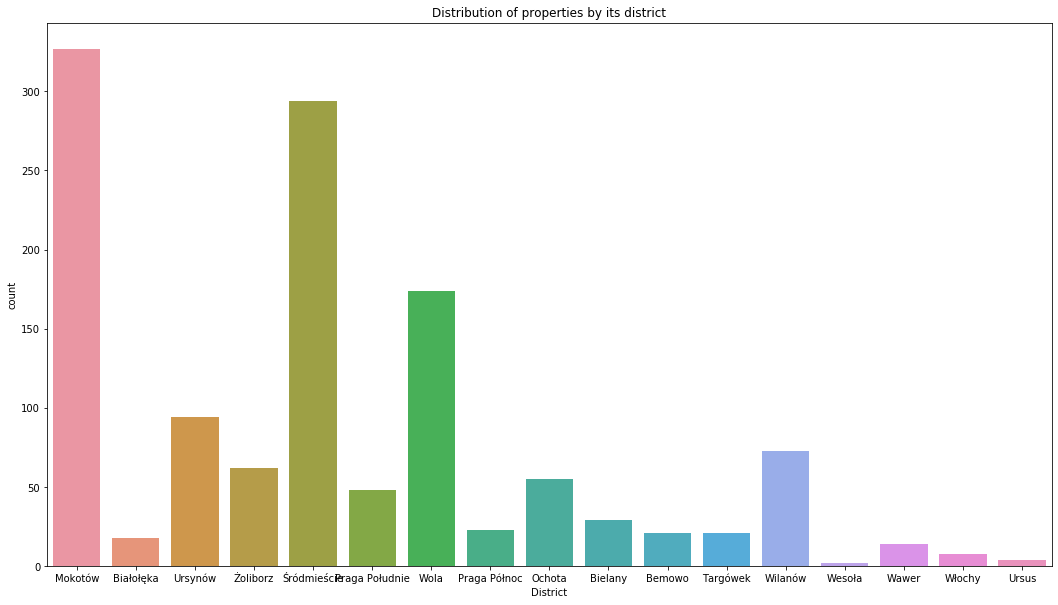

In [44]:
plt.figure(figsize=(18,10))
ax = sns.countplot(x="District", data=rental_properties)
plt.title('Distribution of properties by its district')
plt.xlabel('District')

## Visualize the average price & average apartment size per district on a choropleth map

### Firstly let's calculate the mean per district.

In [45]:
ByDistrict = rental_properties.groupby(['District']).mean().reset_index()
ByDistrict

,District,Price,Latitude,Longitude,property_area
0,Bemowo,2785.238095,52.238974,20.913288,64.714286
1,Białołęka,2477.777778,52.319665,21.021177,55.793333
2,Bielany,2830.344828,52.285043,20.943949,66.586207
3,Mokotów,3771.651376,52.193987,21.045781,65.265260
4,Ochota,3246.527273,52.212225,20.972630,64.560000
5,Praga Południe,3063.958333,52.237396,21.071258,53.937500
6,Praga Północ,2655.652174,52.264884,21.027344,49.217391
7,Targówek,2630.952381,52.275192,21.058085,57.809524
8,Ursus,2525.000000,52.196098,20.882899,64.000000
9,Ursynów,2973.085106,52.141039,21.032321,65.957979


### Visualization of the given results.

In [75]:
# create a plain map of Warsaw
mapa = folium.Map(location=[l1, l2], zoom_start=9)

borough_markers = folium.FeatureGroup(name="Borough markers",)

# create a numpy array of length 6 and has linear spacing from the minium price to the maximum price
threshold_scale = np.linspace(ByDistrict['Price'].min(),
                              ByDistrict['Price'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum price

# create a numpy array of length 6 and has linear spacing from the minium average property area to the max average property area
threshold_scale1 = np.linspace(ByDistrict['property_area'].min(),
                              ByDistrict['property_area'].max(),
                              6, dtype=int)
threshold_scale1 = threshold_scale1.tolist() 
threshold_scale1[-1] = threshold_scale1[-1] + 1 

for lat, lng, borough in zip(ByDistrict['Latitude'], ByDistrict['Longitude'],
                             ByDistrict['District']):
    
    pop = folium.Popup(f"{borough}", parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=pop,
        color='purple',
        fill=True,
        fill_color='#66023c',
        fill_opacity=0.7,
        parse_html=False).add_to(borough_markers)

mapa.choropleth(
    geo_data=gj,
    data=ByDistrict,
    columns=['District','Price'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    threshold_scale=threshold_scale,
    name = 'Average Price by District',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Price by District'
)

mapa.choropleth(
    geo_data=gj,
    data=ByDistrict,
    columns=['District','property_area'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale1,
    fill_color='YlOrRd', 
    name = 'Average Property Area by District',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Property Area by District'
)

# Add markers

borough_markers.add_to(mapa)


# Add map tiles in as a toggleable feature

folium.TileLayer('OpenStreetMap',overlay=True,name="Map tiles").add_to(mapa)
    
# Add layer controls to the map

folium.LayerControl().add_to(mapa)

# Display the map
    
mapa


# Let's use the FourSquare API, to get details of venues in a particular area.

In [47]:
CLIENT_ID = 'J0X1ZITI2QFGRFSFUHQTYVV1FN31IWDIFW0WZMNRSX3EWNOA' #Foursquare ID
CLIENT_SECRET = 'BFJEJC0MABHCQPQCBXRF5ERXL5YGSGOQMSQMUPSP4A4SAU3D' # Foursquare Secret
VERSION = '20200605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: J0X1ZITI2QFGRFSFUHQTYVV1FN31IWDIFW0WZMNRSX3EWNOA
CLIENT_SECRET:BFJEJC0MABHCQPQCBXRF5ERXL5YGSGOQMSQMUPSP4A4SAU3D


In [48]:
# type your answer here
radius=500
LIMIT=100

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

In [49]:
def getNearbyVenues(names, latitudes, longitudes, radius=500,limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [50]:
warsaw_venues = getNearbyVenues(names=warsaw['District'],
                                   latitudes=warsaw['Latitude'],
                                   longitudes=warsaw['Longitude']
                                  )

Mokotów
Praga Południe
Ursynów
Wola
Bielany
Targówek
Śródmieście
Bemowo
Białołęka
Ochota
Wawer
Praga Północ
Ursus
Żoliborz
Włochy
Wilanów
Rembertów
Wesoła


In [51]:
print('{} venues are collected!'.format(warsaw_venues.shape[0]))

218 venues are collected!


#### We want to select only specific districts.

In [52]:
dist = ByDistrict['District']
list(dist)

['Bemowo',
 'Białołęka',
 'Bielany',
 'Mokotów',
 'Ochota',
 'Praga Południe',
 'Praga Północ',
 'Targówek',
 'Ursus',
 'Ursynów',
 'Wawer',
 'Wesoła',
 'Wilanów',
 'Wola',
 'Włochy',
 'Śródmieście',
 'Żoliborz']

In [53]:
warsaw_venues = warsaw_venues[warsaw_venues['District'].isin(dist)].reset_index(drop=True)
warsaw_venues

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Mokotów,52.193987,21.045781,Green Caffè Nero,52.198116,21.047283,Café
1,Mokotów,52.193987,21.045781,4fun.tv,52.196089,21.046074,Arcade
2,Mokotów,52.193987,21.045781,Sikorskiego,52.192557,21.047922,Skate Park
3,Mokotów,52.193987,21.045781,Tor stegny 02,52.191261,21.046389,Bus Station
4,Mokotów,52.193987,21.045781,Restauracja Giovanni Sport,52.190349,21.045084,Diner
...,...,...,...,...,...,...,...
211,Wilanów,52.153083,21.110441,La millou,52.151070,21.113367,Baby Store
212,Wesoła,52.251794,21.229276,Korty Tenisowe Wesoła,52.250449,21.224401,Tennis Court
213,Wesoła,52.251794,21.229276,Klimat,52.253798,21.223714,Pizza Place
214,Wesoła,52.251794,21.229276,Warszawa Wesoła,52.253798,21.223625,Train Station


In [54]:
warsaw_venues.groupby('District').count()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Bemowo,14,14,14,14,14,14
Białołęka,1,1,1,1,1,1
Bielany,9,9,9,9,9,9
Mokotów,6,6,6,6,6,6
Ochota,20,20,20,20,20,20
Praga Południe,4,4,4,4,4,4
Praga Północ,10,10,10,10,10,10
Targówek,6,6,6,6,6,6
Ursus,4,4,4,4,4,4


In [55]:
print('There are {} uniques categories.'.format(len(warsaw_venues['Venue Category'].unique())))

There are 92 uniques categories.


In [56]:
warsaw_venues['Venue Category'].value_counts()

Café                        16
Coffee Shop                  9
Park                         8
Bus Station                  8
Italian Restaurant           7
                            ..
Miscellaneous Shop           1
Bike Rental / Bike Share     1
Convenience Store            1
Dim Sum Restaurant           1
Road                         1
Name: Venue Category, Length: 92, dtype: int64

The most popular venue in our dataset is Cafe.

# Let's analyze each district

In [57]:
# one hot encoding
warsaw_onehot = pd.get_dummies(warsaw_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
warsaw_onehot['District'] = warsaw_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [warsaw_onehot.columns[-1]] + list(warsaw_onehot.columns[:-1])
warsaw_onehot = warsaw_onehot[fixed_columns]

warsaw_onehot.head()

,District,Accessories Store,Arcade,Art Museum,Asian Restaurant,Athletics & Sports,Baby Store,Bakery,Bar,Basketball Court,...,Sushi Restaurant,Tennis Court,Thai Restaurant,Theme Park Ride / Attraction,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoga Studio
0,Mokotów,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Mokotów,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Mokotów,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Mokotów,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Mokotów,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by district and by taking the mean of the frequency of occurrence of each category

In [58]:
warsaw_grouped = warsaw_onehot.groupby('District').mean().reset_index()
warsaw_grouped

,District,Accessories Store,Arcade,Art Museum,Asian Restaurant,Athletics & Sports,Baby Store,Bakery,Bar,Basketball Court,...,Sushi Restaurant,Tennis Court,Thai Restaurant,Theme Park Ride / Attraction,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoga Studio
0,Bemowo,0.000000,0.000000,0.000000,0.000000,0.071429,0.0,0.000000,0.000000,0.00,...,0.000000,0.00,0.000000,0.000000,0.000000,0.142857,0.00,0.000000,0.000000,0.000000
1,Białołęka,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
2,Bielany,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
3,Mokotów,0.000000,0.166667,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
4,Ochota,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.05,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.05,0.000000,0.050000,0.000000
5,Praga Południe,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
6,Praga Północ,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.10,...,0.000000,0.00,0.000000,0.000000,0.000000,0.100000,0.00,0.000000,0.000000,0.000000
7,Targówek,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
8,Ursus,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,...,0.000000,0.00,0.000000,0.000000,0.250000,0.000000,0.00,0.000000,0.000000,0.000000
9,Ursynów,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000


#### First, let's write a function to sort the venues in descending order.

In [59]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Now let's create a new dataframe and display the top 10 venues for each district.

In [65]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for idx in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(idx+1, indicators[idx]))
    except:
        columns.append('{}th Most Common Venue'.format(idx+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = warsaw_grouped['District']

for idx in np.arange(warsaw_grouped.shape[0]):
    district_venues_sorted.iloc[idx, 1:] = return_most_common_venues(warsaw_grouped.iloc[idx, :], num_top_venues)

In [66]:
district_venues_sorted

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bemowo,Food & Drink Shop,Tram Station,Bus Station,Supermarket,Italian Restaurant,Sandwich Place,Café,Sporting Goods Shop,Donut Shop,Coffee Shop
1,Białołęka,Business Service,Dim Sum Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Convenience Store,Cupcake Shop,Deli / Bodega,Department Store
2,Bielany,Park,Bus Station,Gym,Drugstore,Ice Cream Shop,Metro Station,Coffee Shop,Pharmacy,Flea Market,Basketball Court
3,Mokotów,Café,Skate Park,Arcade,Bus Station,Diner,Lake,Cocktail Bar,Coffee Shop,Comedy Club,Convenience Store
4,Ochota,Hotel,Pharmacy,Basketball Court,Business Service,Park,Burger Joint,Polish Restaurant,Italian Restaurant,Department Store,Dessert Shop
5,Praga Południe,Café,Bus Line,Road,Ice Cream Shop,Dessert Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Convenience Store
6,Praga Północ,Bike Rental / Bike Share,Tram Station,Bus Station,Pharmacy,Comedy Club,Drugstore,Convenience Store,Basketball Court,Plaza,Light Rail Station
7,Targówek,Bus Station,Pet Store,Flea Market,Gym / Fitness Center,Cupcake Shop,Dessert Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club
8,Ursus,Park,Train Station,Supermarket,Hotel,Dessert Shop,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club
9,Ursynów,Grocery Store,Supermarket,Italian Restaurant,Dessert Shop,Food Court,Plaza,Bus Stop,Food & Drink Shop,Bar,Coffee Shop


# Let's cluster districts

In [67]:
# set number of clusters
kclusters = 2

clustering = warsaw_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

#### Let's create a new dataframe that includes the cluster as well as the price and the top 10 venues for each neighborhood.

In [68]:
# add clustering labels
district_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# add average price for each district
warsaw_merged = pd.merge(district_venues_sorted, ByDistrict)

#### Finally, let's visualize the resulting clusters

In [76]:
# create map
map_clusters = folium.Map(location=[l1,l2], zoom_start=12)

# set colors
rainbow = ['blue', 'red','green','black','pink','yellow','white','brown']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(warsaw_merged['Latitude'], warsaw_merged['Longitude'], warsaw_merged['District'], warsaw_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Examine Clusters

## Cluster 1

In [70]:
cluster1 = warsaw_merged.loc[warsaw_merged['Cluster Labels'] == 0, warsaw_merged.columns[[1] + list(range(5, warsaw_merged.shape[1]))]]
cluster1

,District,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Price,Latitude,Longitude,property_area
12,Wilanów,Cocktail Bar,Coffee Shop,Comedy Club,Convenience Store,Cupcake Shop,Deli / Bodega,Department Store,3915.890411,52.153083,21.110441,72.050685


## Cluster 2

In [71]:
cluster2 = warsaw_merged.loc[warsaw_merged['Cluster Labels'] == 1, warsaw_merged.columns[[1] + list(range(5, warsaw_merged.shape[1]))]]
cluster2

,District,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Price,Latitude,Longitude,property_area
0,Bemowo,Supermarket,Italian Restaurant,Sandwich Place,Café,Sporting Goods Shop,Donut Shop,Coffee Shop,2785.238095,52.238974,20.913288,64.714286
1,Białołęka,Cocktail Bar,Coffee Shop,Comedy Club,Convenience Store,Cupcake Shop,Deli / Bodega,Department Store,2477.777778,52.319665,21.021177,55.793333
2,Bielany,Drugstore,Ice Cream Shop,Metro Station,Coffee Shop,Pharmacy,Flea Market,Basketball Court,2830.344828,52.285043,20.943949,66.586207
3,Mokotów,Bus Station,Diner,Lake,Cocktail Bar,Coffee Shop,Comedy Club,Convenience Store,3771.651376,52.193987,21.045781,65.265260
4,Ochota,Business Service,Park,Burger Joint,Polish Restaurant,Italian Restaurant,Department Store,Dessert Shop,3246.527273,52.212225,20.972630,64.560000
5,Praga Południe,Ice Cream Shop,Dessert Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Convenience Store,3063.958333,52.237396,21.071258,53.937500
6,Praga Północ,Pharmacy,Comedy Club,Drugstore,Convenience Store,Basketball Court,Plaza,Light Rail Station,2655.652174,52.264884,21.027344,49.217391
7,Targówek,Gym / Fitness Center,Cupcake Shop,Dessert Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,2630.952381,52.275192,21.058085,57.809524
8,Ursus,Hotel,Dessert Shop,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,2525.000000,52.196098,20.882899,64.000000
9,Ursynów,Dessert Shop,Food Court,Plaza,Bus Stop,Food & Drink Shop,Bar,Coffee Shop,2973.085106,52.141039,21.032321,65.957979


# THE END